# One more thing - deep information

During Chenjie's another project, he trained a transfer learning model in order to classify ['oiseaux', 'Trace_humain', 'autre_animaux', 'paysage', 'humain'], images of these 5 labels. This transfer learning model is based on VIT which is a image classification model pre-trained on ImageNet. So the interesting point is that in the ImageNet's 1000 labels, there's no one about human. But after training the last linear layer, the new transfer leaning model showed a good performance of Identify human. So how can it do that ?

In [1]:
# import the libraries
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))
print( torch. __version__)

Using device cuda
2.1.1


### Load and check model structure

In [3]:
from pathlib import Path

# load model state dict
MODEL_PATH = Path("models")
MODEL_NAME = "transfer_learning_model_88.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

reload_model = torch.load(MODEL_SAVE_PATH)

# put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
reload_model.to(device)


print(f"Loaded model:\n{reload_model}")
print(f"Model on device:\n{next(reload_model.parameters()).device}")

Loaded model:
VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine

#### Test set image preprocessing-RCTN

In [4]:
from torchvision import transforms
# Scale, Crop, Turn Tensor, Normalize
image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

In [5]:
# test image
image_path = Path('./dataset/test/trace_humain')

In [6]:
# image preprocessing
image_path_list = list(image_path.glob("*.jpg")) + list(image_path.glob("*.jpeg"))

In [7]:
from torchinfo import summary


for param in reload_model.conv_proj.parameters():
    param.requires_grad = True

for param in reload_model.encoder.parameters():
    param.requires_grad = True

## check layers after changing layers
summary(reload_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              1,024                True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   787,456              True
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              True
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      12,596,224           True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 197, 10

### Let transfer learning model classify our image

In [8]:
# set your CAM extractor
from vit_grad_rollout import VITAttentionGradRollout

print(type(reload_model))

<class 'torchvision.models.vision_transformer.VisionTransformer'>


`IMPRTANT`: Here we extract `the last layer` before the linear layer

In [9]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

target_layers =[reload_model.encoder.layers[-2]]
print(target_layers)

cam = GradCAM(model=reload_model, target_layers=target_layers, reshape_transform=reshape_transform)

[EncoderBlock(
  (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  (mlp): MLPBlock(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): Dropout(p=0.0, inplace=False)
  )
)]


In [10]:
class_labels = ['oiseaux', 'Trace_humain', 'autre_animaux', 'paysage', 'humain']

In [11]:
import random
from torchcam.utils import overlay_mask


### See results of classification and CAM

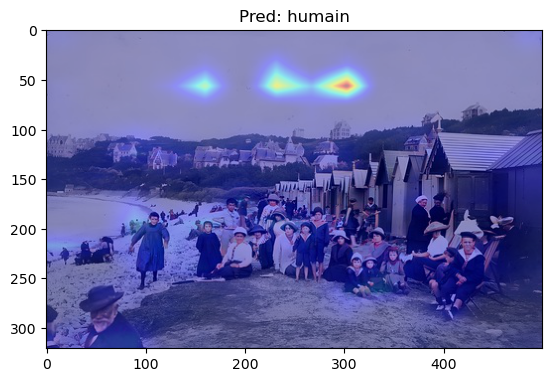

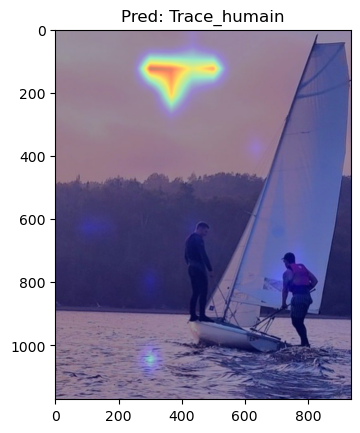

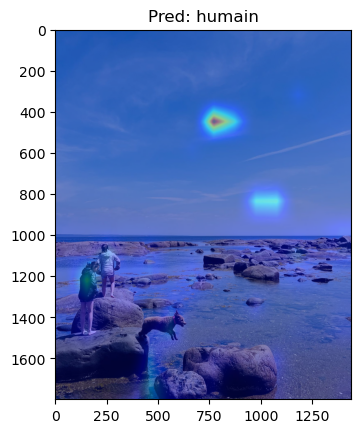

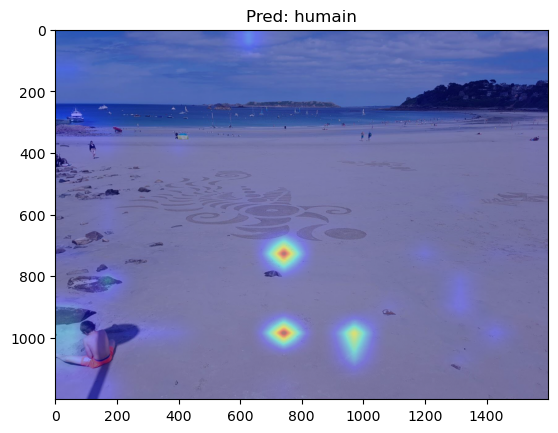

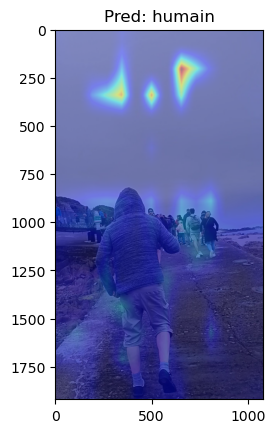

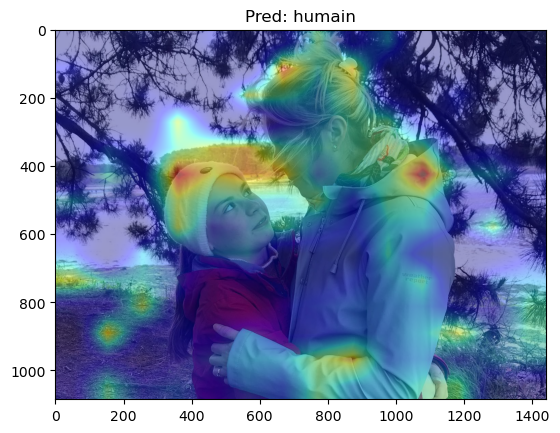

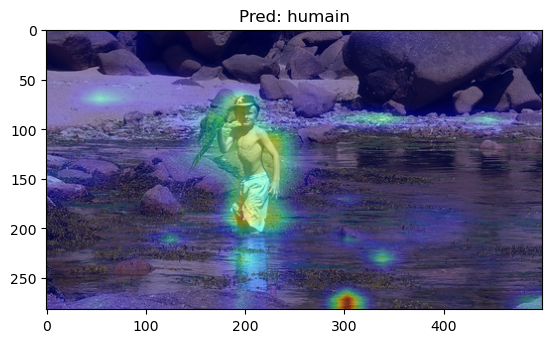

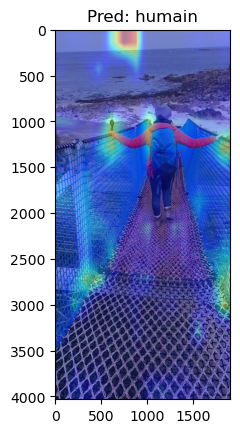

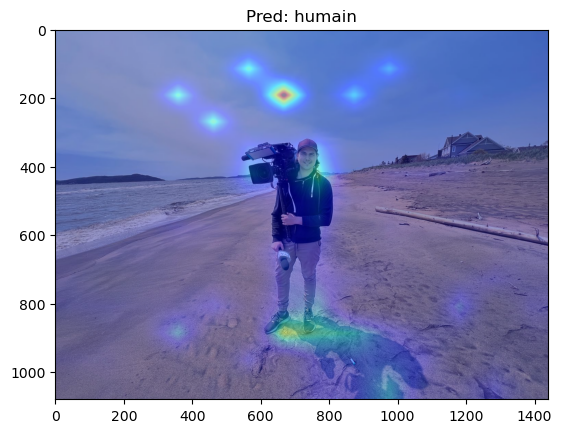

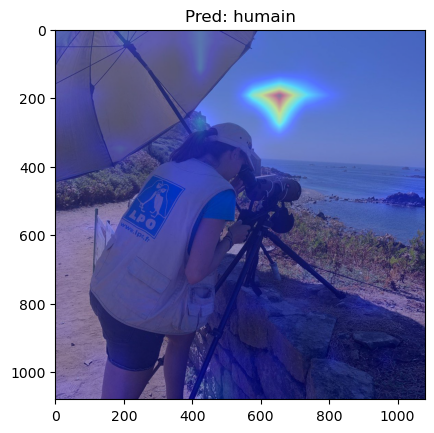

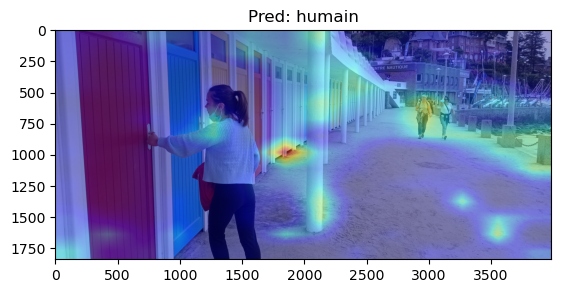

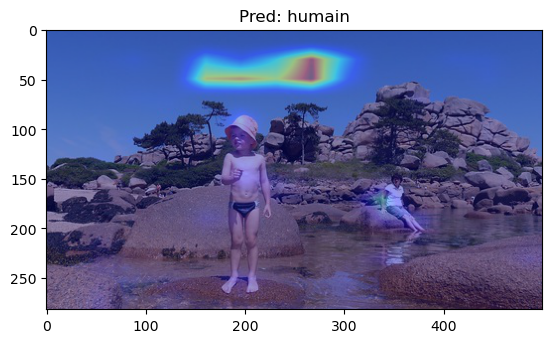

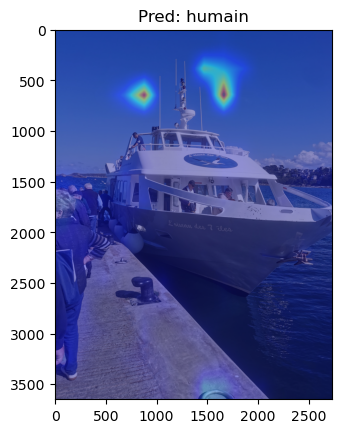

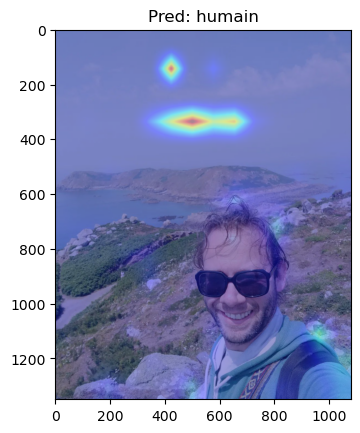

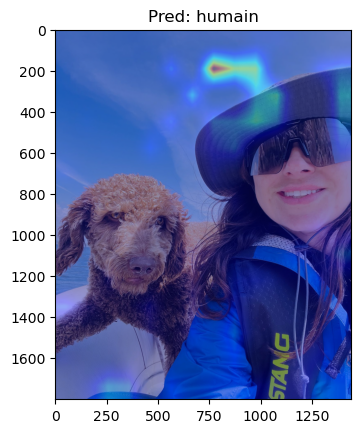

In [12]:

random_image_paths = random.sample(image_path_list, k=15)
for path in random_image_paths:
        img = Image.open(path)
        with torch.inference_mode():
                # transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
                transformed_image = image_transform(img).unsqueeze(dim=0)

                # make a prediction on image with an extra dimension and send it to the target device
                target_image_pred = reload_model(transformed_image.to(device))

        # convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        # convert prediction probabilities -> prediction labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

        input_tensor = image_transform(img).unsqueeze(0).to(device)

        cam_map = cam(input_tensor=input_tensor)[0]

        result = overlay_mask(img, Image.fromarray(cam_map), alpha=0.6)
        plt.title(f"Pred: {class_labels[target_image_pred_label]}")
        plt.imshow(result)
        plt.show()

`IMPRTANT`: Here we extract `the second last layer` before the linear layer

It was clear that the last layer showed meaningless information. So we extracted the second last layer. This time, the neural network's thinking was cleanly displayed to us.
We can assume that the model seems to discover humans by finding human hair as well as objects that are closely associated with humans such as pants. It is precisely these features that the misidentified model also fails to discover.

Due to time constraints, we didn't have a chance to go into all of this as well as explain it, but it seems that there is a lot of unexpected information hidden within neural networks.

[EncoderBlock(
  (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  (mlp): MLPBlock(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): Dropout(p=0.0, inplace=False)
  )
)]


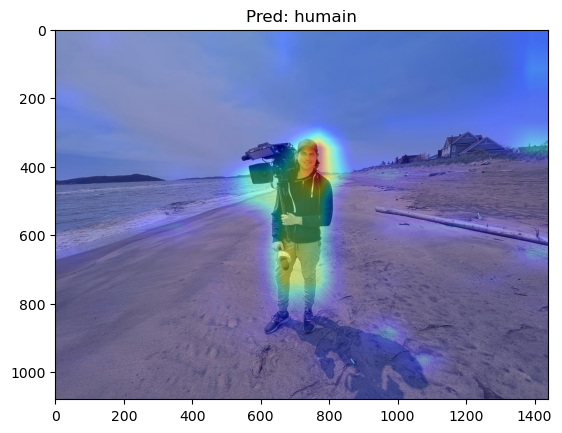

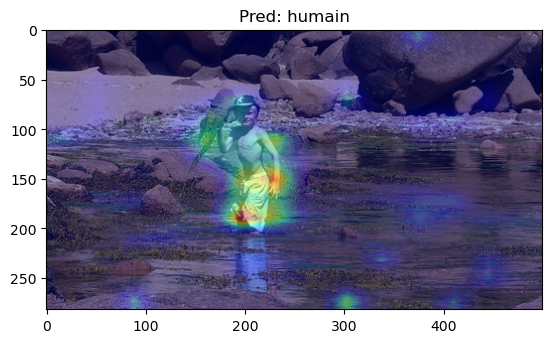

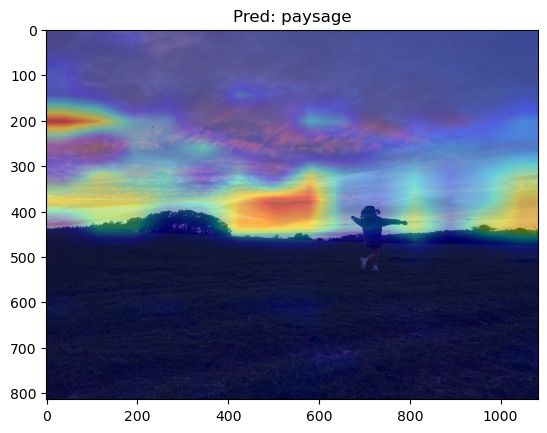

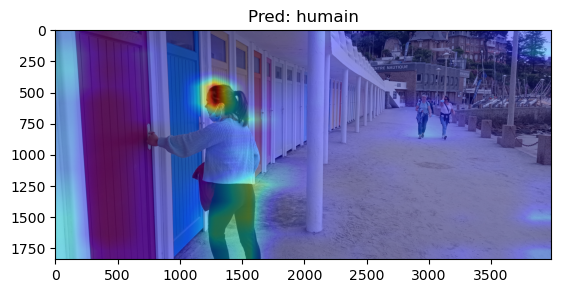

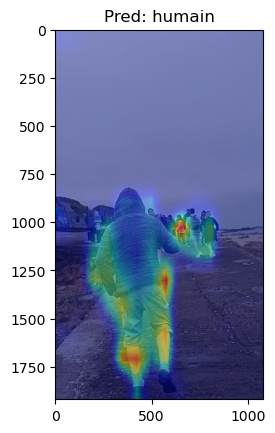

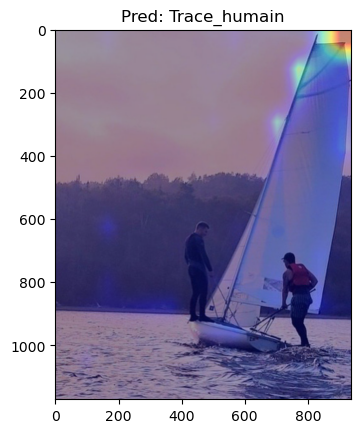

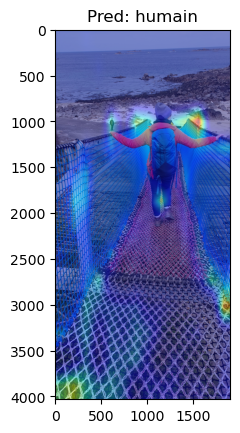

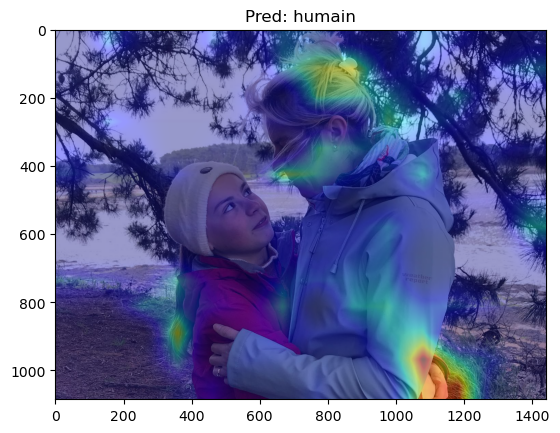

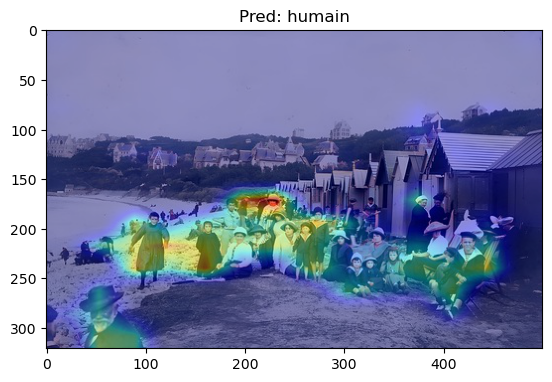

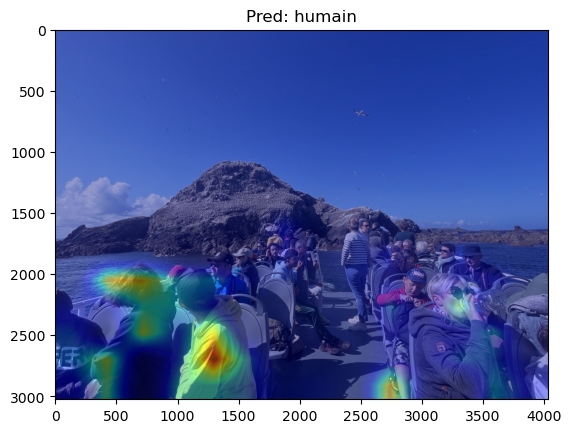

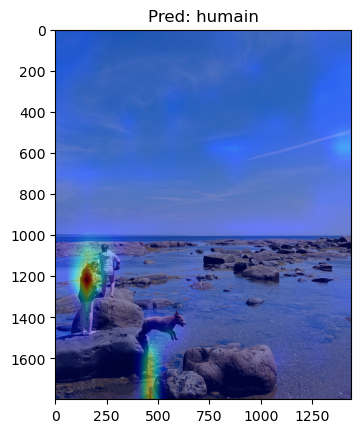

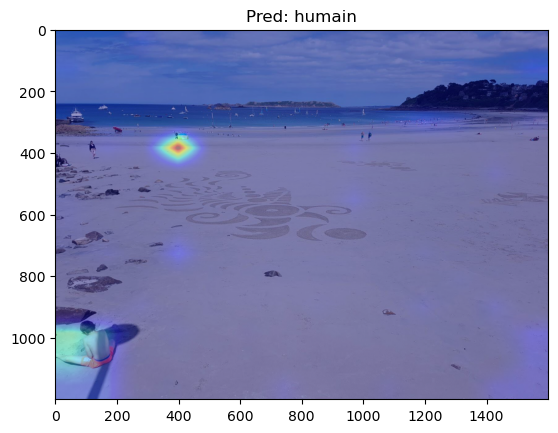

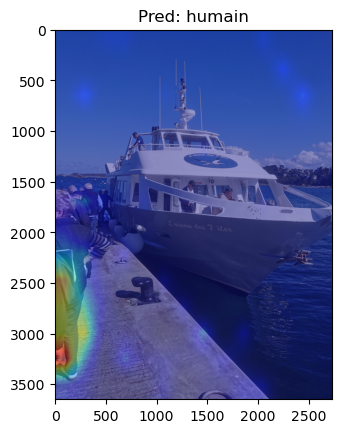

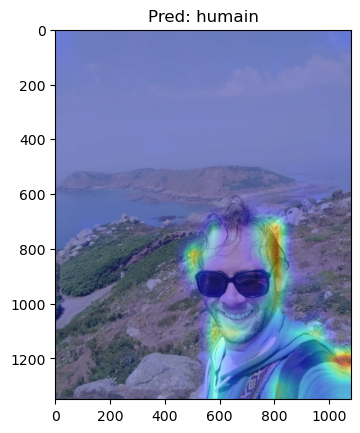

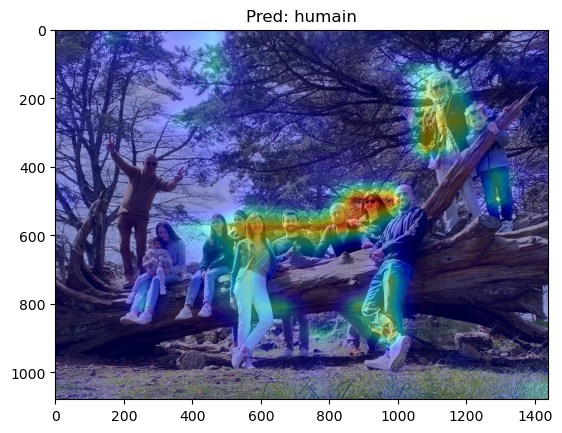

In [13]:
target_layers =[reload_model.encoder.layers[-3]]
print(target_layers)

cam = GradCAM(model=reload_model, target_layers=target_layers, reshape_transform=reshape_transform)


random_image_paths = random.sample(image_path_list, k=15)
for path in random_image_paths:
        img = Image.open(path)
        with torch.inference_mode():
                # transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
                transformed_image = image_transform(img).unsqueeze(dim=0)

                # make a prediction on image with an extra dimension and send it to the target device
                target_image_pred = reload_model(transformed_image.to(device))

        # convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        # convert prediction probabilities -> prediction labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

        input_tensor = image_transform(img).unsqueeze(0).to(device)

        cam_map = cam(input_tensor=input_tensor)[0]

        result = overlay_mask(img, Image.fromarray(cam_map), alpha=0.6)
        plt.title(f"Pred: {class_labels[target_image_pred_label]}")
        plt.imshow(result)
        plt.show()